# Set up enviroment

In [4]:
!pip install optuna optuna-integration

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib

import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Input, Dense, Dropout, LSTM
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

import optuna
from optuna.visualization import plot_optimization_history
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

from datetime import datetime
import os
import math
import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.8 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
tokens = ["btc", "eth", "xrp"]
train_test_split = ["721", "622", "811"]

data_source = '/content/drive/My Drive/Report_DBA/final_report/'
processed_output_dir = os.path.join(data_source,  "processing/")

targets = ["Close"]

data_set = {1: "train", 2: "test", 3: "validation"}

model_name = "lstm"

T = 60 # ----> lookback
TF = 1 # ----> predict
NFeature = 1 # ----> feautures
n_try_opt = 100
# working on
token_id = 1

# n_split = 0 # 721
n_split = 1 # 622
# n_split = 2 # 811

In [7]:
%cd $data_source

/content/drive/My Drive/Report_DBA/final_report


In [8]:
# load scaler
scaler = joblib.load(os.path.join(f"{processed_output_dir}/{tokens[token_id]}/{train_test_split[n_split]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

# Get raw data

In [9]:
def getData(data_dir = "processing", subset = "train", token_id  = 0):
    df = pd.read_excel(f"{data_dir}/{tokens[token_id]}/{train_test_split[n_split]}/{targets[0]}_{subset}_scaler.xlsx")
    df.drop(columns=["Unnamed: 0"], inplace=True)
    return df

# Define supervised data

In [10]:
def getSupervisedData(T, TF, train, test, val):
    # TRAIN
    series = train.to_numpy()
    X = []
    Y = []
    for t in range(len(series) - T - TF + 1):
      x = series[t:t+T,-1]
      X.append(x)

      y = series[t+T:t+T+TF,-1]
      Y.append(y)
    Xtrain = np.array(X).astype(float)
    Ytrain = np.array(Y).astype(float).reshape(len(Y),)

    # TEST
    series = np.concatenate([train.to_numpy()[-T:],test.to_numpy()])
    X = []
    Y = []
    for t in range(len(series) - T - TF + 1):
      x = series[t:t+T,-1]
      X.append(x)

      y = series[t+T:t+T+TF,-1]
      Y.append(y)
    Xtest = np.array(X).astype(float)
    Ytest = np.array(Y).astype(float).reshape(len(Y),)

    # VAL
    series = np.concatenate([test.to_numpy()[-T:],val.to_numpy()])
    X = []
    Y = []
    for t in range(len(series) - T - TF + 1):
      x = series[t:t+T,-1]
      X.append(x)

      y = series[t+T:t+T+TF,-1]
      Y.append(y)
    Xval = np.array(X).astype(float)
    Yval = np.array(Y).astype(float).reshape(len(Y),)

    return Xtrain,Ytrain, Xtest,Ytest, Xval, Yval

# Build Model

In [11]:
def LSTMModel(trial, T, NFeature):
  model = Sequential()
  model.add(Input(shape=(T, NFeature)))

  drop_out = trial.suggest_float('Dropout_rate', 0.01, 0.1)
  lstm_layers = trial.suggest_int("nLayers", 1, 6)
  hidden_size = trial.suggest_int("Hidden_size", 32, 512, step=16)
  learning_rate = trial.suggest_float('lr', 1e-4, 1e-2)

  for i in range(lstm_layers-1):
        model.add(LSTM(hidden_size,return_sequences=True))
  model.add(LSTM(hidden_size))
  model.add(Dropout(drop_out))
  model.add(Dense(TF))


  opt = optimizers.Adam(learning_rate)
  model.compile(
    loss='mse',
    optimizer=opt,
  )
  return model

## function: objective()

In [12]:
def objective(trial):
    epochs = trial.suggest_int('epochs', 100, 500)
    batch_size = trial.suggest_int('batch_size', 16, 64, step=16)


    # keras.backend.clear_session()
    # Generate our trial model.
    model = LSTMModel(trial,T,NFeature)

    # Fit the model on the training data.
    # The TFKerasPruningCallback checks for pruning condition every epoch.
    model.fit(
        Xtrain,
        Ytrain,
        batch_size=batch_size,
        callbacks=[TFKerasPruningCallback(trial, "val_loss")],
        epochs=epochs,
        validation_data=[Xval, Yval],
        verbose=0,
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(Xval, Yval, verbose=0)
    return score

## Optimize

In [13]:
def optimizedHyperParam():
  start=datetime.now()
  study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner())
  study.optimize(objective, n_trials=n_try_opt)
  pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
  complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
  plot_optimization_history(study)
  return study.best_trial.params

# Start

In [14]:
df_train = getData(subset="train")
df_test = getData(subset="test")
df_val = getData(subset="validation")

In [15]:
Xtrain, Ytrain, Xtest, Ytest, Xval, Yval = getSupervisedData(T, TF, df_train, df_test, df_val)

In [16]:
Xtrain = np.expand_dims(Xtrain, axis=2)

Xtest = np.expand_dims(Xtest, axis=2)

Xval = np.expand_dims(Xval, axis=2)


## TUNING HYPERPARAMS

In [17]:
# start_proccess=datetime.now()

# best_params = optimizedHyperParam()

# print("Process time all:",datetime.now()-start_proccess)

In [18]:
# best_params

## TRAINING

In [19]:
def LSTMModel_training(lstm_layers, hidden_size, dropout, learning_rate):
  model = Sequential()
  model.add(Input(shape=(T, NFeature)))

  for i in range(lstm_layers-1):
        model.add(LSTM(hidden_size,return_sequences=True))
  model.add(LSTM(hidden_size))
  model.add(Dropout(dropout))
  model.add(Dense(TF, activation='sigmoid'))


  opt = optimizers.Adam(learning_rate)
  model.compile(
    loss='mse',
    optimizer=opt,
  )
  return model

In [20]:
# epochs = best_params.get("epochs")
# lstm_layers = best_params.get("nLayers")
# hidden_size = best_params.get("Hidden_size")
# lr = best_params.get("lr")
# dropout_rate = best_params.get("Dropout_rate")
# batch_size = best_params.get("batch_size")

epochs = 200
lstm_layers = 2
hidden_size = 256
lr = 1e-3
dropout_rate = 0.05
batch_size = 32


model = LSTMModel_training(lstm_layers = lstm_layers,
                          hidden_size = hidden_size,
                          dropout = dropout_rate,
                          learning_rate = lr)
history = model.fit(
        Xtrain,
        Ytrain,
        epochs=epochs,
        batch_size=batch_size
      )

model.save(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}_{train_test_split[n_split]}")
with open(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}_history", 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

Epoch 1/200
36/36 [==============================] - 34s 741ms/step - loss: 0.0403
Epoch 2/200
36/36 [==============================] - 15s 429ms/step - loss: 0.0181
Epoch 3/200
36/36 [==============================] - 16s 437ms/step - loss: 0.0237
Epoch 4/200
36/36 [==============================] - 15s 426ms/step - loss: 0.0047
Epoch 5/200
36/36 [==============================] - 15s 431ms/step - loss: 0.0019
Epoch 6/200
36/36 [==============================] - 19s 515ms/step - loss: 0.0012
Epoch 7/200
36/36 [==============================] - 17s 474ms/step - loss: 0.0011
Epoch 8/200
36/36 [==============================] - 16s 433ms/step - loss: 0.0011
Epoch 9/200
36/36 [==============================] - 15s 431ms/step - loss: 0.0012
Epoch 10/200
36/36 [==============================] - 15s 428ms/step - loss: 9.9430e-04
Epoch 11/200
36/36 [==============================] - 16s 432ms/step - loss: 8.4927e-04
Epoch 12/200
36/36 [==============================] - 15s 428ms/step - loss: 

# Test and Visulization

In [21]:
def evaluate(df, title, actual, predict):
  rmse = np.sqrt(mean_squared_error(actual, predict))
  mae = mean_absolute_error(actual, predict)
  mape = mean_absolute_percentage_error(actual, predict)

  df[f"rmse_{title}"].append(rmse)
  df[f"mae_{title}"].append(mae)
  df[f"mape_{title}"].append(mape)
  return df


In [22]:
model = tf.keras.models.load_model(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}_{train_test_split[n_split]}")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 256)           264192    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 789,761
Trainable params: 789,761
Non-trainable params: 0
_________________________________________________________________


In [23]:
# model.get_config()

In [24]:
metrics_df = {
    "rmse_train": [],
    "mae_train": [],
    "mape_train": [],
    "rmse_test": [],
    "mae_test": [],
    "mape_test": [],
    "rmse_val": [],
    "mae_val": [],
    "mape_val": [],
}
# Dự đoán trên tập huấn luyện
y_pred_train = model.predict(Xtrain)
y_pred_test = model.predict(Xtest)
y_pred_val = model.predict(Xval)

# inverse transform TRAIN
pred_train = scaler.inverse_transform(y_pred_train.reshape(1, -1))
y_true_train = scaler.inverse_transform(Ytrain.reshape(1, -1))

# inverse transform TEST
pred_test = scaler.inverse_transform(y_pred_test.reshape(1, -1))
y_true_test = scaler.inverse_transform(Ytest.reshape(1, -1))

# inverse transform VAL
pred_val = scaler.inverse_transform(y_pred_val.reshape(1, -1))
y_true_val = scaler.inverse_transform(Yval.reshape(1, -1))

metrics_df = evaluate(metrics_df, "train", y_true_train, pred_train)
metrics_df = evaluate(metrics_df, "test", y_true_test, pred_test)
metrics_df = evaluate(metrics_df, "val", y_true_val, pred_val)

metrics_df = pd.DataFrame(metrics_df)

metrics_folder = f"metrics/{tokens[token_id]}"
os.makedirs(metrics_folder, exist_ok=True)
metrics_df.to_excel(f"{metrics_folder}/{model_name}_{train_test_split[n_split]}.xlsx")
metrics_df


13/13 [==============================] - 2s 166ms/step


,rmse_train,mae_train,mape_train,rmse_test,mae_test,mape_test,rmse_val,mae_val,mape_val
0,20.22427,12.538752,0.044696,168.473924,133.953861,0.092937,74.116253,51.139879,0.064182


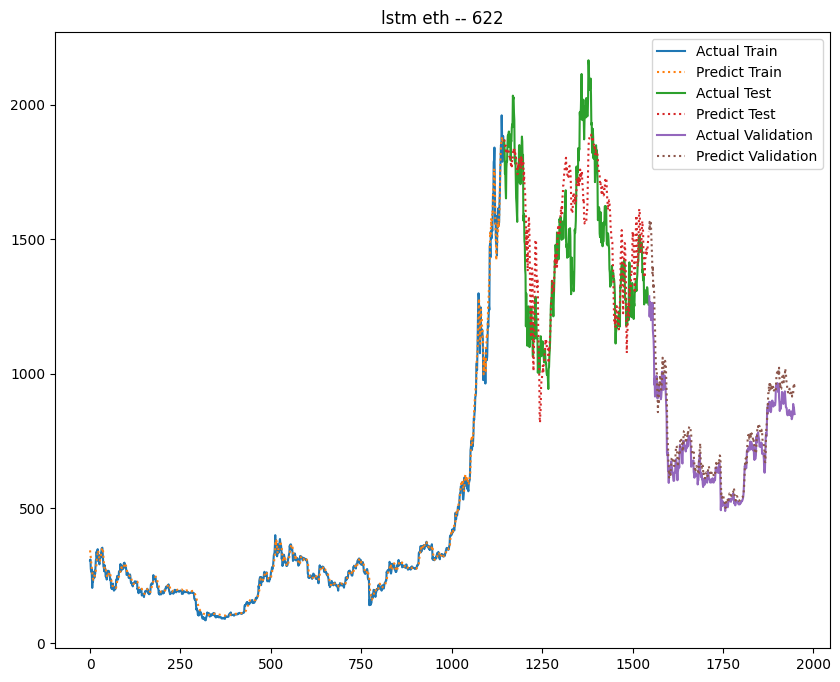

In [25]:
# Predict Next 30 days
npred = 30
i = 0
pred_list = []
input = Yval[-T:]

while i < npred:
  pred = model.predict(input.reshape(1, -1, 1))
  pred_list.append(pred)

  input = np.concatenate([input.squeeze(), pred.reshape(1, )])
  input = input[1:]
  i += 1

pred_list = np.array(pred_list)
pred_list = scaler.inverse_transform(pred_list.reshape(1, -1))

color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

plt.figure(figsize=(10, 8))

# train
train_range = range(0, len(y_true_train.squeeze()))
plt.plot([*train_range], y_true_train.squeeze(), label="Actual Train", color = color_palette[0])
plt.plot([*train_range], pred_train.squeeze(), label="Predict Train", linestyle="dotted", color = color_palette[1])

# test
test_range = range(train_range[-1] + 1, train_range[-1] + 1 + len(y_true_test.squeeze()))
plt.plot([*test_range], y_true_test.squeeze(), label="Actual Test", color=color_palette[2])
plt.plot([*test_range], pred_test.squeeze(), label="Predict Test", linestyle="dotted", color=color_palette[3])

# val
val_range = range(test_range[-1] + 1, test_range[-1] + 1 + len(y_true_val.squeeze()))
plt.plot([*val_range], y_true_val.squeeze(), label="Actual Validation", color=color_palette[4])
plt.plot([*val_range], pred_val.squeeze(), label="Predict Validation", linestyle="dotted",color=color_palette[5])

# 30 days
pred_range = range(val_range[-1] + 1, val_range[-1] + 1 + 30)
plt.plot([*pred_range], pred_list.squeeze(), label="Predict 30 day")

plt.legend()
plt.title(f"{model_name} {tokens[token_id]} -- {train_test_split[n_split]}")

save_folder = f"Figures/{tokens[token_id]}"
os.makedirs(f"{save_folder}", exist_ok=True)
plt.savefig(f"{save_folder}/{model_name}_{train_test_split[n_split]}.png")
plt.show()